# Exploring Popular Data Science Topics on Stack Exchange

## Table of Contents

1. [Introduction and Context](#introduction-and-context)
   - [Stack Exchange](#stack-exchange)
   - [Stack Exchange Data Explorer](#stack-exchange-data-explorer)
2. [Extracting Data for Analysis](#extracting-data-for-analysis)
   - [Getting the Data](#getting-the-data)
   - [Exploring and Cleaning Data](#exploring-and-cleaning-data)
3. [Data Analysis](#data-analysis)
   - [The Most Used and Most Viewed Tags](#the-most-used-and-most-viewed-tags)
     - [How many times was each tag used?](#how-many-times-was-each-tag-used)
     - [How many times was each tag viewed?](#how-many-times-was-each-tag-viewed)
   - [Relations Between Tags](#relations-between-tags)
     - [Relationships Between Pairs of Tags Using the Co-occurrence Matrix](#relationships-between-pairs-of-tags-using-the-co-occurrence-matrix)
     - [Relationships Between Multiple Tags Using Clustering](#relationships-between-multiple-tags-using-clustering)
   - [Domain Knowledge](#domain-knowledge)
   - [Is Deep Learning Just a Fad?](#is-deep-learning-just-a-fad)
4. [Conclusion](#conclusion)
   - [Key Findings](#key-findings)
   - [Recommendations](#recommendations)

## Introduction and Context

## I. Introduction and Context

In this project, I am working for a company that creates data science content similar to [Dataquest](https://www.dataquest.io). My task is to determine the most valuable topics to write about. One approach to this is analyzing the Data Science Stack Exchange (DSSE) platform. DSSE, along with other popular sites like [Stack Overflow](https://stackoverflow.com/), is part of the [Stack Exchange](https://stackexchange.com) network, a collection of question-and-answer websites.

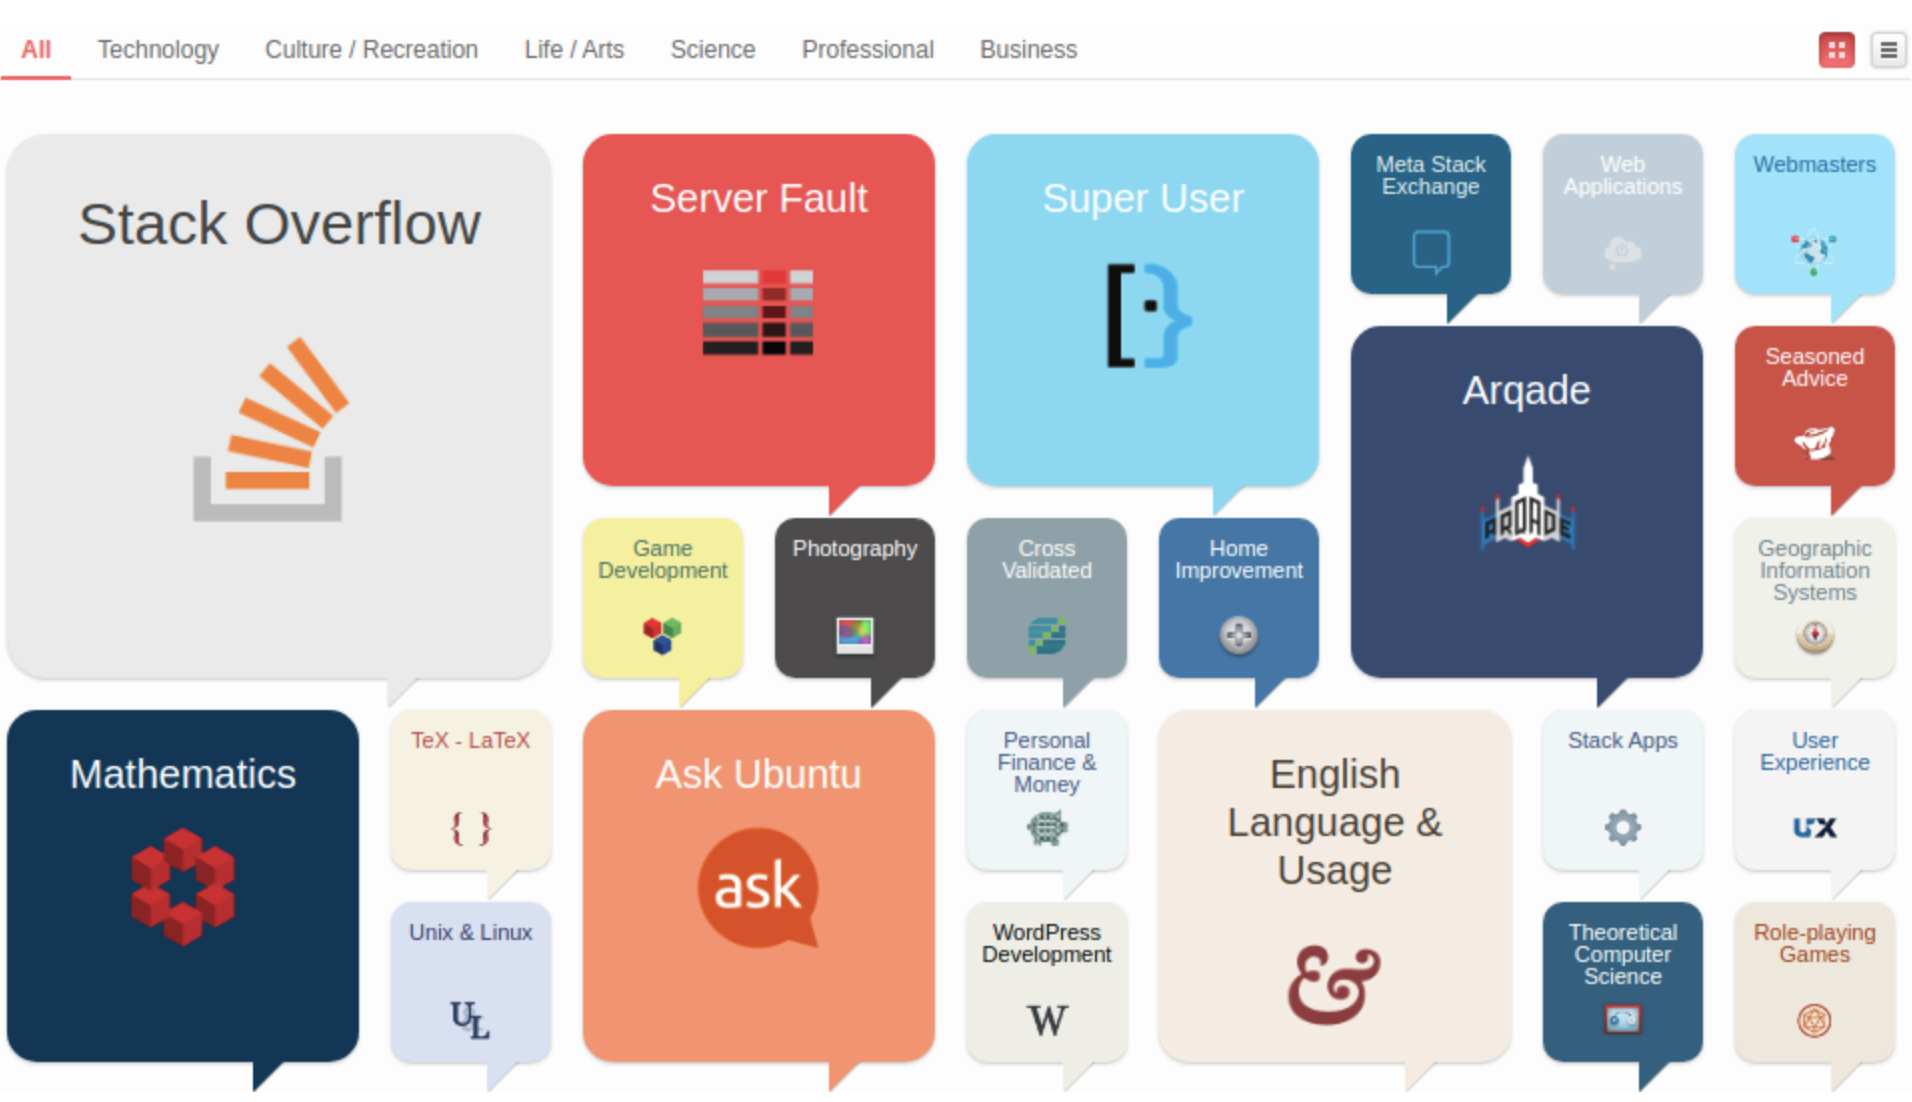

Exploring the questions on DSSE can help my company better tailor educational content, resources, and community engagement efforts to meet the needs of those who want to learn more about Data Science.

To achieve this, we will analyze several subjects:

* The most frequently discussed and viewed Data Science topics on DSSE
* The relationships between different tags, identifying clusters of related topics that often appear together in discussions
* Trends in the interest of specific topics, particularly deep learning, to understand if they are sustained or declining over time 

### 1. Stack Exchange

Stack Exchange hosts many websites, but only a few are relevant to this project. These include:

- Data Science
- Cross Validated
- Artificial Intelligence
- Mathematics
- Stack Overflow
- Database Administrators
- Unix & Linux
- Software Engineering

Data Science Stack Exchange encourages questions that are specific to data science. Questions should be clear, focused, and well-researched, demonstrating that the asker has made an effort to solve the problem independently.

The homepage of DSSE is divided into several sections besides questions: tags, users, jobs, and teams.

### 2. Stack Exchange Data Explorer

Our methodology involves collecting data from the [Stack Exchange Data Explorer (SEDE)](https://data.stackexchange.com/datascience/query/new), a public database provided by Stack Exchange for each of its websites. SEDE uses [Transact-SQL](https://en.wikipedia.org/wiki/Transact-SQL) to retrieve data.

After investigating the website, it is clear that tags will be very useful in categorizing content. For instance, the following code run on SEDE shows the top 20 tags in the database:

```sql
SELECT TOP 20 TagName, COUNT(*) AS TagCount
FROM Tags
JOIN PostTags
ON Tags.Id = PostTags.TagId
GROUP BY TagName
ORDER BY TagCount DESC
```

This query helps us identify the most frequently used tags, which can inform our content strategy.

,TagName,TagCount
0,machine-learning,11468
1,python,6726
2,deep-learning,4907
3,neural-network,4386
4,classification,3285
5,nlp,2753
6,keras,2724
7,scikit-learn,2316
8,tensorflow,2181
9,time-series,1891


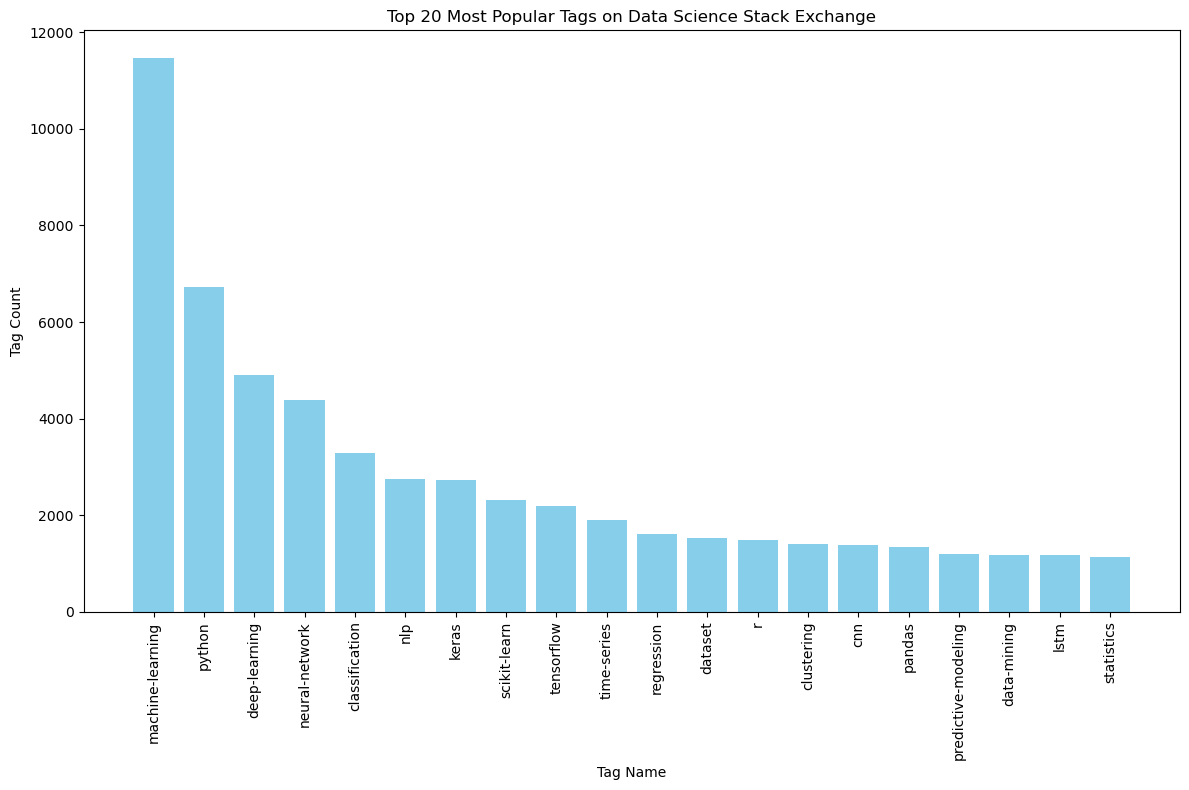

In [4]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Reading the data on the top 20 Tags on SEDE
popular_tags = pd.read_csv('popular_tags.csv')
display(popular_tags)

# Creating a bar plot of the top 20 tags 
plt.figure(figsize=(12, 8))
plt.bar(popular_tags['TagName'], popular_tags['TagCount'], color='skyblue')
plt.xlabel('Tag Name')
plt.ylabel('Tag Count')
plt.title('Top 20 Most Popular Tags on Data Science Stack Exchange')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The analysis of the most popular tags on Data Science Stack Exchange reveals a strong focus on machine learning and its subfields, particularly deep learning. Python dominates as the primary programming language, with significant mentions of related libraries such as TensorFlow, Keras, and scikit-learn. There is also notable interest in natural language processing, time series analysis, and essential techniques like classification and regression.

## II. Extracting Data for Analysis

### 1. Getting the Data

The post table has many columns, but we will focus only on those relevant to our goal:

- `Id`: An identification number for the post
- `PostTypeId`: An identification number for the type of post
- `CreationDate`: The date and time of creation of the post
- `Score`: The post's score
- `ViewCount`: How many times the post was viewed
- `Tags`: What tags were used
- `AnswerCount`: How many answers the question received (only applicable to question posts)
- `FavoriteCount`: How many times the question was favored (only applicable to question posts)

There are eight different types of posts, but we will only focus on questions. Since we are only interested in recent posts, we will limit our analysis to posts from 2023.

The following query extracts the data for our analysis:

```sql
SELECT
    p.Id,
    p.PostTypeId,
    p.CreationDate,
    p.Score,
    p.ViewCount,
    p.Tags,
    p.AnswerCount,
    p.FavoriteCount
FROM 
    Posts p
WHERE 
    p.PostTypeId = 1  -- Ensures we are selecting questions only
    AND p.CreationDate >= '2023-01-01'
    AND p.CreationDate < '2024-01-01'
ORDER BY 
    p.CreationDate
```

This query selects the relevant columns from the posts table, filtering to include only question posts created in 2023.

In [7]:
# Reading the Data 
data_questions = pd.read_csv('questions_2023.csv')
display(data_questions)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,117435,1,2023-01-01 03:32:10,0,54,<nlp><feature-selection><feature-engineering><...,1,NaN
1,117436,1,2023-01-01 11:42:00,0,96,<deep-learning><time-series><convolutional-neu...,1,NaN
2,117439,1,2023-01-01 12:54:09,0,2381,<neural-network><keras><tensorflow><convolutio...,0,NaN
3,117444,1,2023-01-02 01:14:52,8,9213,<nlp><gpu><language-model><memory>,1,NaN
4,117447,1,2023-01-02 05:52:18,1,98,<python><pytorch><computer-vision><torchvision>,1,NaN
...,...,...,...,...,...,...,...,...
2621,126227,1,2023-12-30 15:22:07,0,17,<recommender-system><k-means><k-nn>,0,NaN
2622,126230,1,2023-12-30 19:37:11,0,83,<machine-learning><neural-network><pytorch>,2,NaN
2623,126232,1,2023-12-30 23:20:51,0,40,<optimization>,0,NaN
2624,126234,1,2023-12-31 07:21:42,0,13,<machine-learning><algorithms><association-rules>,0,NaN


### 2. Exploring and Cleaning Data

Upon initial inspection, the `FavoriteCount` column contains only missing values. Since this column is entirely empty and not crucial for the rest of the analysis, we will drop it.

Additionally, we will convert the `CreationDate` column from an object type to a datetime type for better data manipulation. Furthermore, since the `Tags` column contains tags in a single string separated by angle brackets, we will extract individual tags into a list for each row. This allows us to create a new column or dataframe where each tag is a separate binary feature for more advanced analysis.

In [9]:
# Convert CreationDate to datetime and Processing the Tags column

# Convert CreationDate to datetime
data_questions['CreationDate'] = pd.to_datetime(data_questions['CreationDate'])

# Process the Tags column
data_questions['Tags'] = data_questions['Tags'].apply(lambda x: x.strip('<>').split('><'))

# Drop the column with null values
data_questions.drop(columns=['FavoriteCount'], inplace=True)

# Display the updated DataFrame
data_questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount
0,117435,1,2023-01-01 03:32:10,0,54,"[nlp, feature-selection, feature-engineering, ...",1
1,117436,1,2023-01-01 11:42:00,0,96,"[deep-learning, time-series, convolutional-neu...",1
2,117439,1,2023-01-01 12:54:09,0,2381,"[neural-network, keras, tensorflow, convolutio...",0
3,117444,1,2023-01-02 01:14:52,8,9213,"[nlp, gpu, language-model, memory]",1
4,117447,1,2023-01-02 05:52:18,1,98,"[python, pytorch, computer-vision, torchvision]",1


## III. Data Analysis

### 1. The Most Used and Most Viewed Tags

To determine the popularity of different tags, we will count how many times each tag was used and how many times a question with that tag was viewed. While there are other methods to assess tag popularity, we will focus on these two metrics.

#### A. How many times was each tag used?

We can answer this question by using the code below and analyzing the subsequent bar plot.

                Tag  Count
0  machine-learning    714
1            python    389
2     deep-learning    324
3               nlp    271
4    neural-network    200
5       time-series    200
6    classification    172
7        tensorflow    151
8       transformer    134
9           pytorch    133


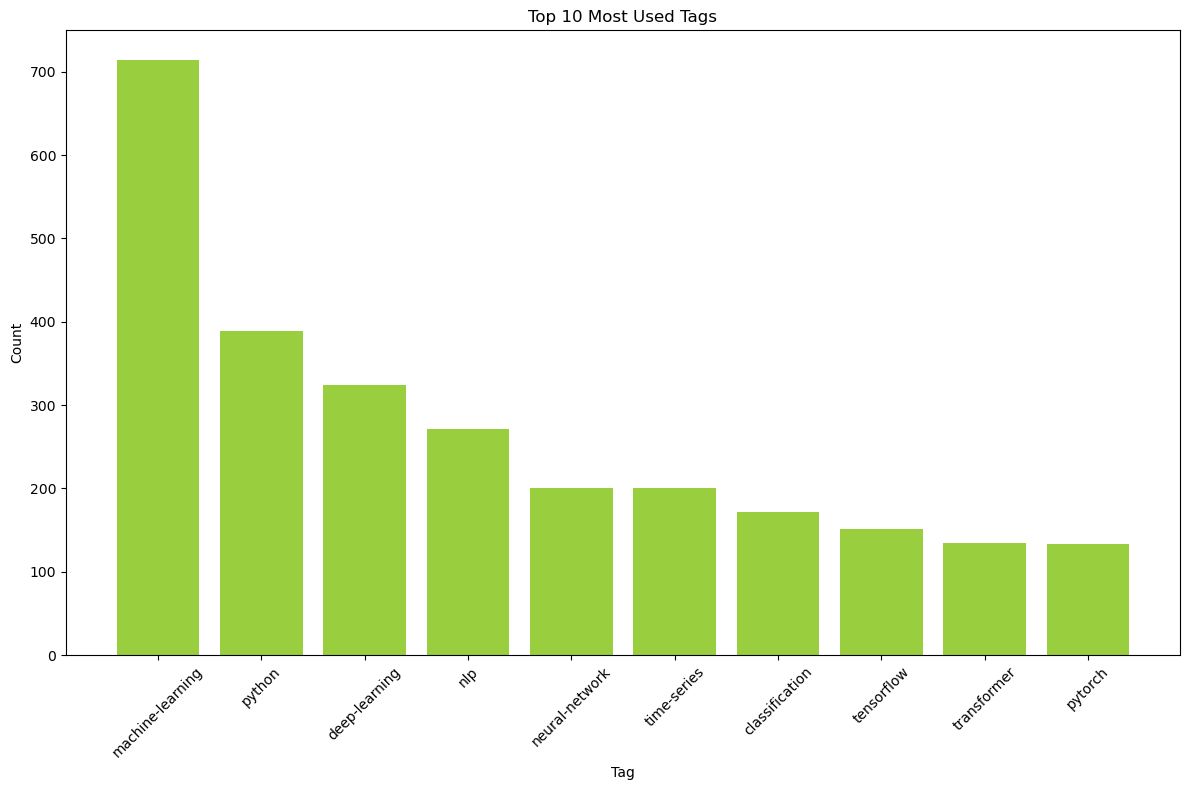

In [11]:
# Copying the DataFrame
data_questions = data_questions.copy()  
# Explode the Tags column to create a row for each tag in each question
tags_exploded = data_questions.explode('Tags')

# Count how many times each tag was used
tag_counts = tags_exploded['Tags'].value_counts().reset_index()
tag_counts.columns = ['Tag', 'Count']

# Display the top tags by count
print(tag_counts.head(10))

# Plot the top 10 tags by count
top_tags_by_count = tag_counts.head(10)

plt.figure(figsize=(12, 8))
plt.bar(top_tags_by_count['Tag'], top_tags_by_count['Count'], color='#99ce3e')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Top 10 Most Used Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The analysis of the most used tags provides valuable insights into the key areas of interest within the data science community. The strong focus on machine learning, deep learning, Python, and specific applications like natural language processing (NLP) and time series analysis highlights the critical topics that drive discussions and research. This information can guide content creation to address the most relevant and sought-after topics in the field.

#### B. How many times was each tag viewed?

We can answer this question by running the following code and analyzing the generated visualization. This will help us understand which topics attract the most attention and engagement within the data science community.

                  Tag  TotalViews
347               nlp      149957
295  machine-learning      148356
212               gpt      100228
414            python       93737
536       transformer       90601
273    language-model       70911
417           pytorch       64901
122     deep-learning       63560
344    neural-network       48740
62            chatbot       32409


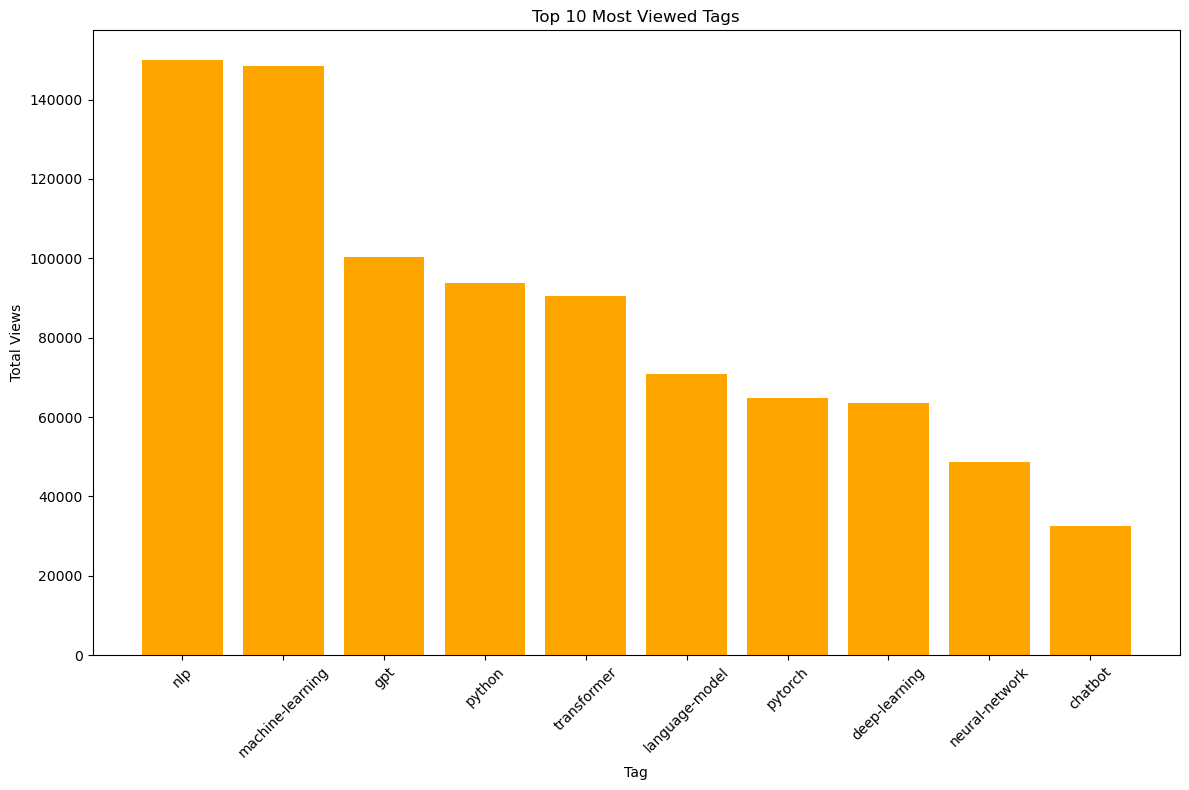

In [14]:
# Copying the DataFrame
data_questions = data_questions.copy()

# Explode the Tags column to create a row for each tag in each question
tags_exploded = data_questions.explode('Tags')

# Calculate the total views for each tag
tag_views = tags_exploded.groupby('Tags')['ViewCount'].sum().reset_index()
tag_views.columns = ['Tag', 'TotalViews']

# Sort the tags by total views in descending order
tag_views = tag_views.sort_values(by='TotalViews', ascending=False)

# Display the top tags by total views
print(tag_views.head(10))

# Plot the top 10 tags by total views
top_tags_by_views = tag_views.head(10)

plt.figure(figsize=(12, 8))
plt.bar(top_tags_by_views['Tag'], top_tags_by_views['TotalViews'], color='orange')
plt.xlabel('Tag')
plt.ylabel('Total Views')
plt.title('Top 10 Most Viewed Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The analysis of the most viewed tags reveals that natural language processing, machine learning, and deep learning are the top areas of interest within the data science community. Python remains the primary language for implementing these techniques, while specialized applications such as chatbots also attract significant attention. This insight underscores the importance of these topics and can help tailor content to meet the community's interests and needs.

### 2. Relations Between Tags

From the previous analysis, we observed that the most used tags are also among the most viewed tags without exception. Let's verify this statement.

In [17]:
# Check if any tags in tag_counts are not in tag_views
tags_only_in_counts = set(tag_counts['Tag']) - set(tag_views['Tag'])
print(f"Tags only in counts: {tags_only_in_counts}")

# Check if any tags in tag_views are not in tag_counts
tags_only_in_views = set(tag_views['Tag']) - set(tag_counts['Tag'])
print(f"Tags only in views: {tags_only_in_views}")

# Confirm if the sets of tags match
all_tags_match = set(tag_counts['Tag']) == set(tag_views['Tag'])
print(f"All tags in counts are also in views: {all_tags_match}")

Tags only in counts: set()
Tags only in views: set()
All tags in counts are also in views: True


There are many ways we could examine the relationships between pairs of tags. One method is using a co-occurrence matrix. Other useful methods include:

- **Jaccard similarity:** Defined as the size of the intersection divided by the size of the union of the sets of questions containing each tag. Higher similarity scores indicate stronger relationships.
- **Cosine similarity:** Create a tag-question matrix where each row represents a tag and each column represents a question.
- **Association rules:** These help discover rules such as "if a question contains tag A, it is likely to contain tag B," identifying strong tag associations.

To keep this analysis concise, we will use only the co-occurrence matrix.

#### A. Relationships Between Pairs of Tags Using the Co-occurrence Matrix

We will create a matrix where each cell (i, j) represents the number of times tag `i` and tag `j` appear together in the same question. This approach helps identify tags that frequently co-occur, providing insights into related topics and trends within the data science community.

                 Tag1              Tag2  Count
156  machine-learning     deep-learning    106
157     deep-learning  machine-learning    106
170  machine-learning            python     99
171            python  machine-learning     99
167    classification  machine-learning     73
166  machine-learning    classification     73
310  machine-learning    neural-network     68
311    neural-network  machine-learning     68
158  machine-learning               nlp     65
159               nlp  machine-learning     65


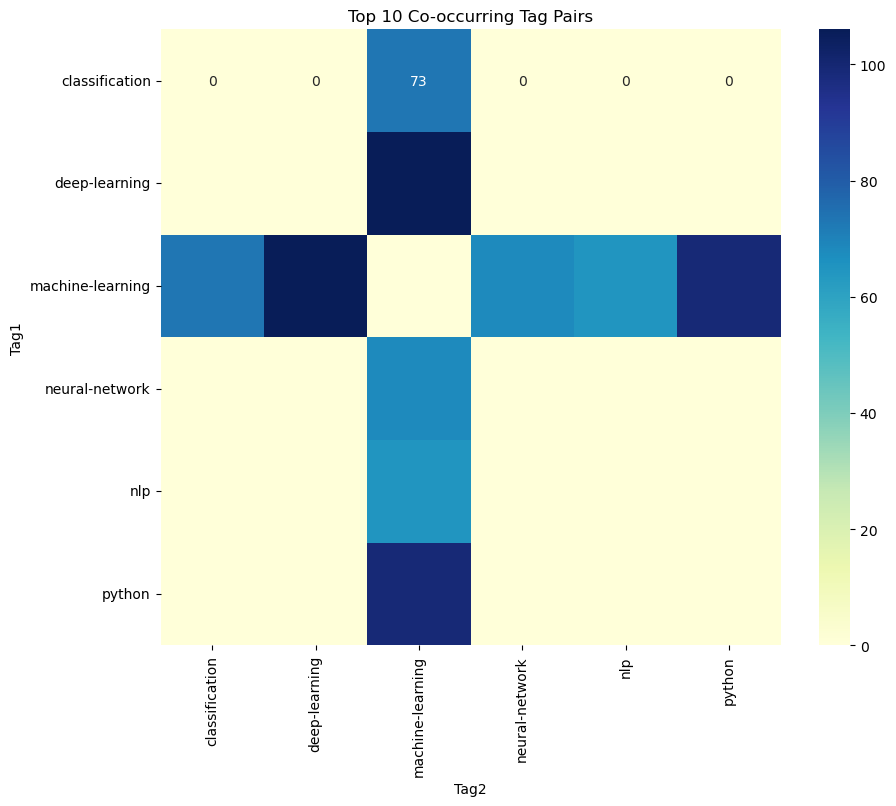

In [19]:
from itertools import combinations
from collections import defaultdict

tags_exploded = data_questions.explode('Tags')

# Create a co-occurrence matrix
co_occurrence = defaultdict(int)

# Iterate through each question and count co-occurrences
for tags in tags_exploded.groupby('Id')['Tags'].apply(list):
    for tag1, tag2 in combinations(tags, 2):
        co_occurrence[(tag1, tag2)] += 1
        co_occurrence[(tag2, tag1)] += 1

# Convert to DataFrame for easier manipulation
co_occurrence_df = pd.DataFrame(
    [(tag1, tag2, count) for (tag1, tag2), count in co_occurrence.items()],
    columns=['Tag1', 'Tag2', 'Count']
)

# Display the top co-occurring pairs
print(co_occurrence_df.sort_values(by='Count', ascending=False).head(10))

# Visualization
co_occurrence_data = {
    'Tag1': ['machine-learning', 'deep-learning', 'machine-learning', 'python', 
             'classification', 'machine-learning', 'machine-learning', 'neural-network',
             'machine-learning', 'nlp'],
    'Tag2': ['deep-learning', 'machine-learning', 'python', 'machine-learning',
             'machine-learning', 'classification', 'neural-network', 'machine-learning',
             'nlp', 'machine-learning'],
    'Count': [106, 106, 99, 99, 73, 73, 68, 68, 65, 65]
}

# Create DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence_data)

# Ensure all pairs are included (even if count is zero)
tags = list(set(co_occurrence_df['Tag1']).union(set(co_occurrence_df['Tag2'])))
complete_data = {'Tag1': [], 'Tag2': [], 'Count': []}

for tag1 in tags:
    for tag2 in tags:
        if tag1 != tag2:
            count = co_occurrence_df[(co_occurrence_df['Tag1'] == tag1) & (co_occurrence_df['Tag2'] == tag2)]['Count']
            if count.empty:
                complete_data['Tag1'].append(tag1)
                complete_data['Tag2'].append(tag2)
                complete_data['Count'].append(0)
            else:
                complete_data['Tag1'].append(tag1)
                complete_data['Tag2'].append(tag2)
                complete_data['Count'].append(count.values[0])

complete_df = pd.DataFrame(complete_data)

# Pivot the DataFrame for heatmap
heatmap_data = complete_df.pivot_table(index="Tag1", columns="Tag2", values="Count", fill_value=0)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")  # Use ".0f" for float formatting with zero decimals
plt.title("Top 10 Co-occurring Tag Pairs")
plt.savefig('tag_co_occurence_heatmap.png')
plt.show()

The co-occurrence matrix and heatmap reveal significant relationships between various tags. They show a strong relationship between `machine-learning` and `deep-learning`, which makes sense as deep learning is a subfield of machine learning, and questions often involve both concepts. The matrix shows a bidirectional co-occurrence. Additionally, `machine-learning` frequently co-occurs with `python`, which is expected since Python is a popular language for machine learning tasks.

Related concepts such as `classification` and `neural-network` also often co-occur with `machine-learning`. These are fundamental concepts and techniques within the broader field of machine learning, reinforcing their interrelated nature.

The tag `nlp` frequently appears with `machine-learning`, indicating that natural language processing tasks often involve machine learning methods.

To extend the analysis of relationships between multiple tags, we can use techniques such as clustering, topic modeling, dimensionality reduction, hierarchical graph analysis, or latent semantic analysis. However, we will focus only on clustering.

#### B. Relationships Between Multiple Tags Using Clustering

We will apply clustering algorithms (such as K-means) on the tag-question matrix to group tags into clusters based on their co-occurrence patterns. Tags in the same cluster are likely related, helping us understand broader patterns and relationships within the data science community.

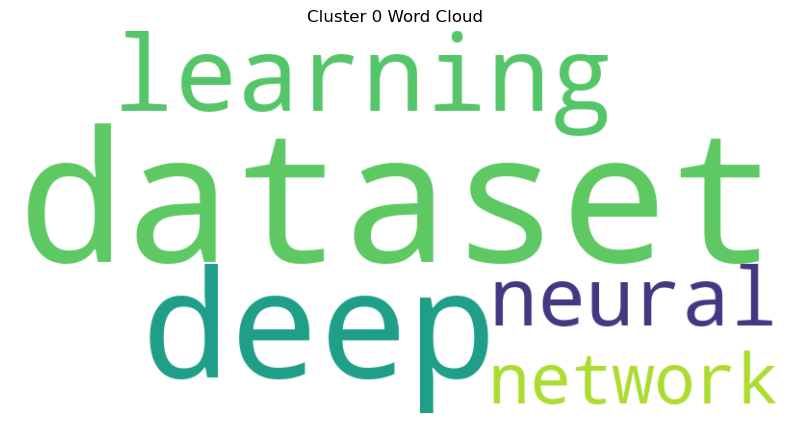

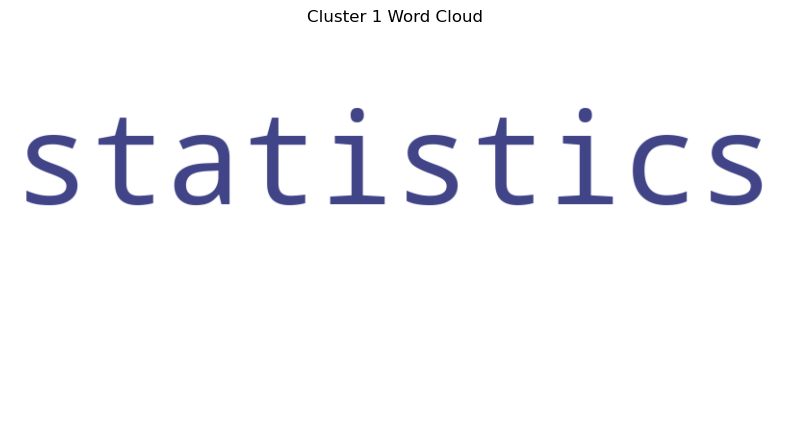

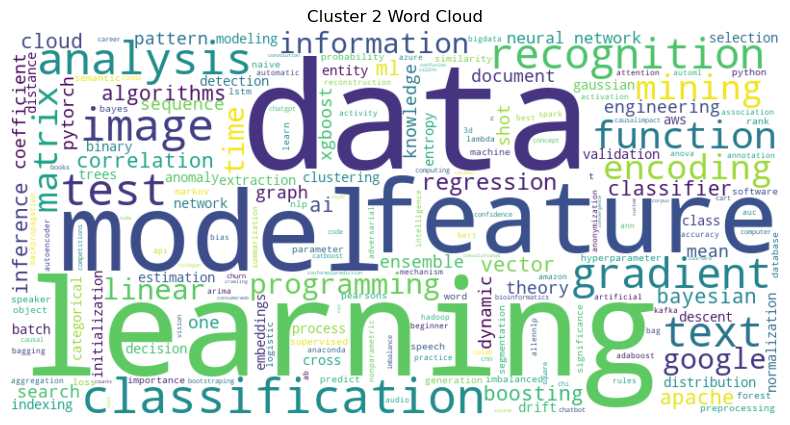

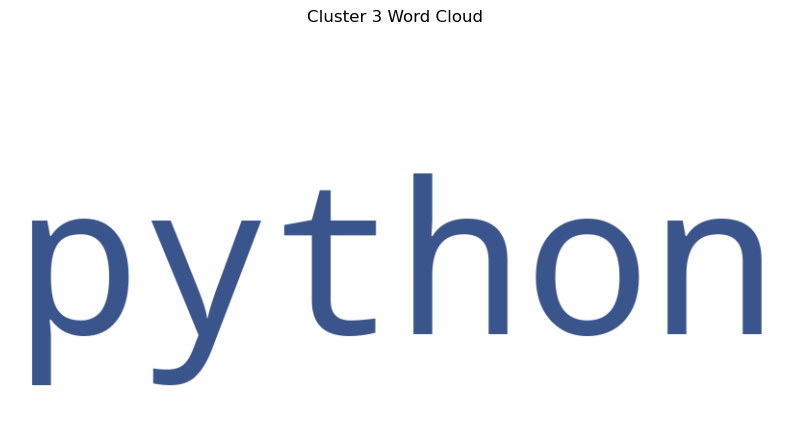

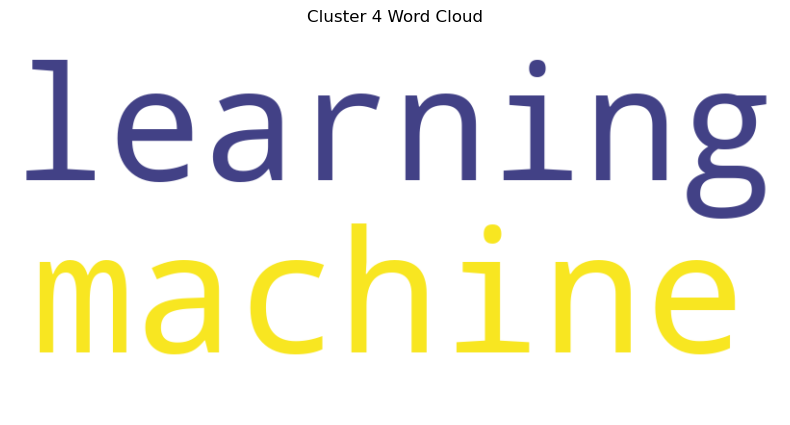

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Flatten the tags into a space-separated string for each question
data_questions['Tags_flat'] = data_questions['Tags'].apply(lambda tags: ' '.join(tags))

# Create a tag-question matrix
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), lowercase=False, token_pattern=None)
tag_question_matrix = vectorizer.fit_transform(data_questions['Tags_flat'])

# Transpose the matrix to make rows represent tags
tag_question_matrix_transposed = tag_question_matrix.T

# Perform K-means clustering on the transposed matrix
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(tag_question_matrix_transposed)

# Assign clusters to tags
terms = vectorizer.get_feature_names_out()
clusters = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(kmeans.labels_):
    clusters[label].append(terms[idx])

# Visualization
from wordcloud import WordCloud

# Function to generate word cloud for a cluster
def generate_wordcloud(cluster_tags, cluster_num):
    text = ' '.join(cluster_tags)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_num} Word Cloud')
    plt.axis('off')
    
    # Save the plot as an image file
    plt.savefig(f'word_cloud_cluster_{cluster_num}.png')
    
    plt.show()

# Generate word clouds for each cluster
for cluster, tags in clusters.items():
    generate_wordcloud(tags, cluster)

The presence of `deep-learning` and `neural-network` in the same cluster suggests a strong focus on advanced machine learning techniques. These tags often co-occur in questions involving complex models and architectures. The inclusion of `dataset` indicates that discussions around data preparation, collection, and usage are integral to deep learning and neural network topics.

Meanwhile, `statistics` represents a focused topic. This suggests that questions related to statistics might often be standalone, reflecting foundational or theoretical aspects of data science.

Cluster 2 is diverse and comprehensive. It includes a wide variety of tags ranging from fundamental concepts (`accuracy`, `algorithms`) to specific techniques (`adaboost`, `attention-mechanism`) and tools (`aws`, `tensorflow`). Tags like `aws`, `azure-ml`, `hadoop`, and `spark` in this cluster suggest a focus on integrating machine learning with cloud computing and big data technologies. Additionally, tags such as `k-means`, `cnn`, `svm`, and `random-forest` indicate discussions around various machine learning methodologies and frameworks. Niche areas with tags like `3d-reconstruction`, `activity-recognition`, and `chatbot` highlight specialized applications of machine learning and AI.

Cluster 3 is programming-focused, with the `python` tag being prominent. This indicates the widespread use and relevance of Python across various data science topics. It suggests that Python is a common tool or language mentioned in many different contexts. It's surprising that R didn't end up in this cluster.

Lastly, similar to the `python` tag, `machine-learning` also forms its own cluster. This underscores its central importance in data science, as machine learning is a fundamental topic that spans a wide array of subfields and applications.

To conclude, the word cloud visualizations effectively highlight the prominence and relationships of different tags within each cluster.

### 3. Domain Knowledge

Using domain knowledge, we can better understand why certain tags might be strongly related. Here is a description of the tags in common (python, machine-learning, deep-learning, neural-network, keras, tensorflow, classification, scikit-learn) and how they relate to each other:

- **Python**: The most popular programming language for data science and machine learning. Most machine learning libraries are either written in Python or have Python interfaces.
- **Machine Learning**: A broad field encompassing various subfields and techniques, including deep learning, neural networks, and classification. Many questions tagged with machine learning will also involve specific libraries (TensorFlow, Keras, Scikit-learn) and techniques (classification).
- **Deep Learning**: A subset of machine learning focused on neural networks with multiple layers. It is often implemented using libraries like TensorFlow and Keras. It is used in complex tasks such as image recognition, natural language processing, and more.
- **Neural Network**: The core architecture for many deep learning models. Deep learning frameworks are used to build and train neural networks. Neural networks are fundamental to deep learning and many machine learning applications.
- **Keras**: A high-level neural networks API written in Python and capable of running on top of TensorFlow. It simplifies the implementation of deep learning models and is widely used in both academic research and industry for rapid prototyping and experimentation with deep learning models.
- **TensorFlow**: An open-source deep learning framework developed by Google. It is used to build and train complex deep learning models. It supports large-scale machine learning and deep learning applications, including neural networks.
- **Classification**: A common machine learning task involving the prediction of categorical labels. It is often implemented using libraries like Scikit-learn, TensorFlow, and Keras. It is used in numerous domains such as spam detection, image classification, and medical diagnosis.
- **Scikit-learn**: A machine learning library for Python, offering simple and efficient tools for data mining and data analysis. It is frequently used for implementing classification, regression, clustering, and more. It is used for traditional machine learning tasks and often paired with Python for end-to-end data science workflows.

Understanding these relationships helps us see how these tags are interconnected, reflecting the practical and theoretical aspects of data science and machine learning.

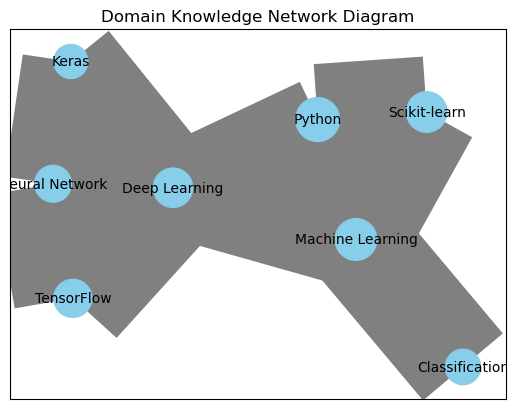

In [24]:
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add nodes with sizes representing their popularity
nodes = {
    'Python': 100, 'Machine Learning': 90, 'Deep Learning': 80, 
    'Neural Network': 70, 'Keras': 60, 'TensorFlow': 75,
    'Classification': 65, 'Scikit-learn': 85
}

for node, size in nodes.items():
    G.add_node(node, size=size)

# Add edges with weights representing the strength of relationships
edges = [
    ('Python', 'Machine Learning', 80), ('Python', 'Deep Learning', 60),
    ('Machine Learning', 'Deep Learning', 70), ('Deep Learning', 'Neural Network', 90),
    ('Neural Network', 'Keras', 70), ('Neural Network', 'TensorFlow', 85),
    ('Machine Learning', 'Classification', 75), ('Python', 'Scikit-learn', 80),
    ('Machine Learning', 'Scikit-learn', 75), ('Deep Learning', 'TensorFlow', 85),
    ('Deep Learning', 'Keras', 70)
]

for u, v, weight in edges:
    G.add_edge(u, v, weight=weight)

# Draw the network
pos = nx.spring_layout(G, seed=42)  # Position nodes using Fruchterman-Reingold force-directed algorithm

# Draw nodes with sizes
node_sizes = [G.nodes[node]['size'] * 10 for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

# Draw edges with weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges]
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Domain Knowledge Network Diagram')
plt.show()

### 4. Is Deep Learning Just a Fad?

Before we make our final recommendation, it's important to solidify our findings with additional proof. Specifically, we want to answer the question: "Is deep learning just a fad?" Ideally, the content we decide to create will remain useful for as long as possible. We need to determine if interest in deep learning is sustained or if it is declining over time.

The file "all_questions.csv" contains the result of a query that fetches all questions ever asked on DSSE, including their dates and tags. Here is the query:

```sql
SELECT Id, CreationDate, Tags
FROM posts
WHERE PostTypeId = 1;
```

To track interest in deep learning over time, we will:

- Count how many deep learning questions are asked per time period.
- Count the total number of questions per time period.
- Calculate the proportion of deep learning questions relative to the total number of questions per time period.

By analyzing these metrics, we can understand whether the interest in deep learning is stable, increasing, or decreasing, and make informed decisions about the focus of our content.

In [26]:
# Reading the File
all_questions = pd.read_csv('all_questions.csv')
# Transform the tags column
all_questions['Tags'] = all_questions['Tags'].apply(lambda x: x.strip('<>').split('><'))
# Display the first few rows of the transformed dataframe
display(all_questions.head(20))

,Id,CreationDate,Tags
0,32685,2018-06-05 15:04:29,"[machine-learning, neural-network, feature-ext..."
1,32688,2018-06-05 15:30:15,"[python, neural-network, tensorflow, tflearn]"
2,32694,2018-06-05 17:34:30,"[machine-learning, neural-network, deep-learni..."
3,32695,2018-06-05 18:30:22,"[time-series, visualization]"
4,32699,2018-06-05 19:57:03,"[deep-learning, gan, generative-models]"
5,32701,2018-06-05 20:40:29,"[python, pandas, numpy]"
6,32703,2018-06-05 21:04:00,"[machine-learning, python]"
7,32705,2018-06-05 21:29:38,"[neural-network, normalization]"
8,32723,2018-06-06 09:04:28,"[statistics, google]"
9,32726,2018-06-06 10:32:30,"[word-embeddings, graphs]"


In [27]:
# Deep Learning questions can be identified by the presence of specific tags such as 'deep-learning', 'neural-network', 'cnn', 'lstm', etc.
# Define a function to identify deep learning questions
deep_learning_tags = ['deep-learning', 'neural-network', 'cnn', 'rnn', 'lstm', 'gan', 'autoencoder', 'transformer']

def is_deep_learning(tags):
    return any(tag in tags for tag in deep_learning_tags)

all_questions['is_deep_learning'] = all_questions['Tags'].apply(is_deep_learning)

# Display the first few rows of the dataframe with the new column
all_questions.head()

,Id,CreationDate,Tags,is_deep_learning
0,32685,2018-06-05 15:04:29,"[machine-learning, neural-network, feature-ext...",True
1,32688,2018-06-05 15:30:15,"[python, neural-network, tensorflow, tflearn]",True
2,32694,2018-06-05 17:34:30,"[machine-learning, neural-network, deep-learni...",True
3,32695,2018-06-05 18:30:22,"[time-series, visualization]",False
4,32699,2018-06-05 19:57:03,"[deep-learning, gan, generative-models]",True


**Tracking Interest in Deep Learning Over Time**

We’ll track interest by counting the number of questions over time. A monthly timeframe is usually a good granularity for observing trends. However, to better visualize the data and for a clearer display, we will use quarterly intervals in our graph.

  YearQuarter  TotalQuestions  DeepLearningQuestions  DeepLearningProportion
0      2014Q2             157                      7                0.044586
1      2014Q3             188                      8                0.042553
2      2014Q4             214                     15                0.070093
3      2015Q1             188                     13                0.069149
4      2015Q2             284                     20                0.070423


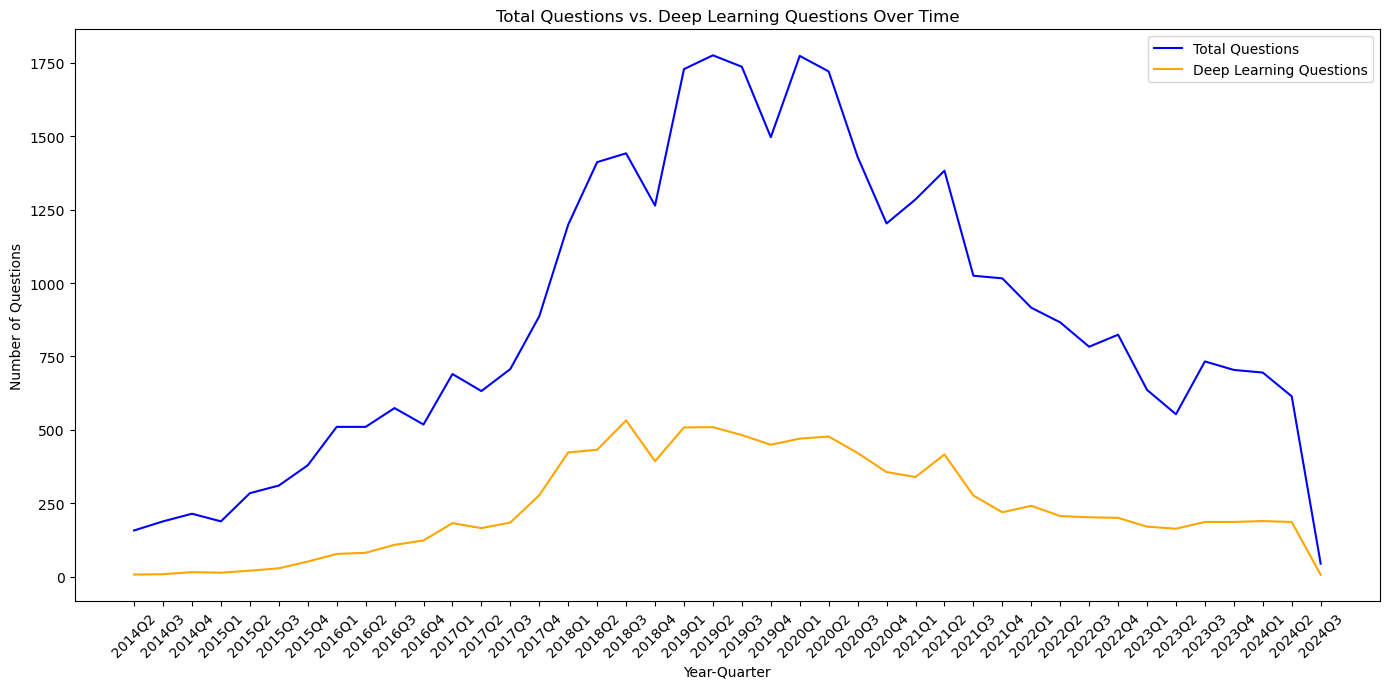

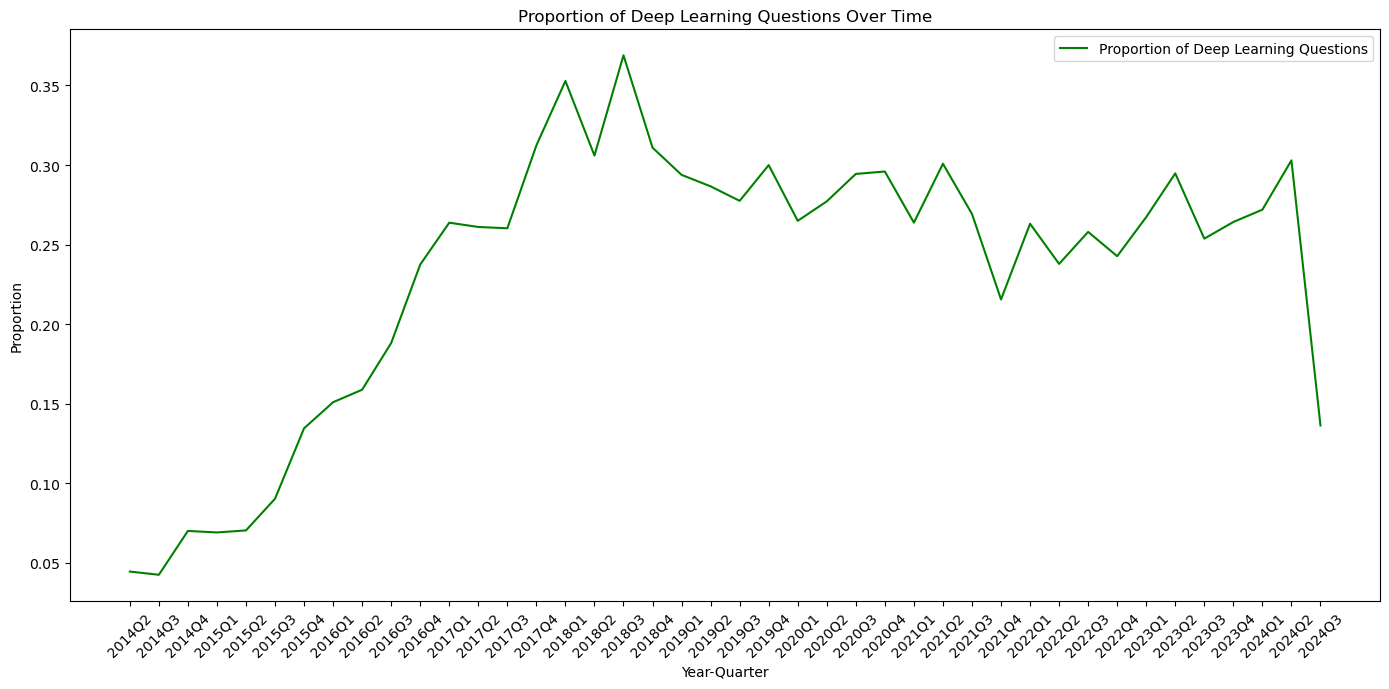

In [29]:
# Convert CreationDate to datetime
all_questions['CreationDate'] = pd.to_datetime(all_questions['CreationDate'])

# Extract year and quarter
all_questions['YearQuarter'] = all_questions['CreationDate'].dt.to_period('Q')

# Count the total number of questions per quarter
total_questions_per_period = all_questions.groupby('YearQuarter').size().reset_index(name='TotalQuestions')

# Count the number of deep learning questions per quarter
deep_learning_questions_per_period = all_questions[all_questions['is_deep_learning']].groupby('YearQuarter').size().reset_index(name='DeepLearningQuestions')

# Merge the dataframes
questions_per_period = pd.merge(total_questions_per_period, deep_learning_questions_per_period, on='YearQuarter', how='left').fillna(0)

# Calculate the relative interest in deep learning
questions_per_period['DeepLearningProportion'] = questions_per_period['DeepLearningQuestions'] / questions_per_period['TotalQuestions']

# Display the first few rows of the dataframe
print(questions_per_period.head())

# Visualization

# Plot total questions and deep learning questions over time
plt.figure(figsize=(14, 7))
plt.plot(questions_per_period['YearQuarter'].astype(str), questions_per_period['TotalQuestions'], label='Total Questions', color='blue')
plt.plot(questions_per_period['YearQuarter'].astype(str), questions_per_period['DeepLearningQuestions'], label='Deep Learning Questions', color='orange')
plt.xlabel('Year-Quarter')
plt.ylabel('Number of Questions')
plt.title('Total Questions vs. Deep Learning Questions Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('total_questions_vs_deep_learning_questions_over_time.png')
plt.show()

# Plot the proportion of deep learning questions over time
plt.figure(figsize=(14, 7))
plt.plot(questions_per_period['YearQuarter'].astype(str), questions_per_period['DeepLearningProportion'], label='Proportion of Deep Learning Questions', color='green')
plt.xlabel('Year-Quarter')
plt.ylabel('Proportion')
plt.title('Proportion of Deep Learning Questions Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('proportion_of_deep_learning_questions_over_time.png')
plt.show()

The trend shows that the number of deep learning questions has changed over time. Its proportion relative to the total number of questions indicates the relative interest in deep learning.

Based on the trends above, if deep learning continues to be a significant portion of the questions, it would be beneficial to focus content creation on deep learning topics. This includes tutorials, articles, and courses that cover deep learning techniques, tools, and applications. However, if interest in deep learning appears to be decreasing, it might be worthwhile to diversify content to include emerging areas of data science and machine learning.

Providing content for a hot topic is valuable, but it's equally important to develop a long-term view by staying at the cutting edge of data science. This approach ensures that we not only meet current demands but also anticipate and lead in future trends.

## IV. Conclusion

### Key Findings

1. **Most Popular Tags**:
   - The tags `machine-learning`, `python`, `deep-learning`, `neural-network`, `tensorflow`, `keras`, `classification`, and `scikit-learn` emerged as the most frequently used and viewed tags, indicating their central importance in data science discussions.

2. **Tag Relationships**:
   - Clustering analysis revealed strong relationships between tags such as `machine-learning` and `deep-learning`, `python` and `pandas`, and other combinations that reflect common workflows and tool usage in data science.

3. **Trends in Deep Learning**:
   - Time series analysis showed that deep learning remains a significant area of interest within the data science community, with a substantial proportion of questions being related to deep learning topics.

### Recommendations

Based on our analysis, we can conclude that foundational and advanced topics in machine learning and deep learning, along with essential tools like Python and related libraries, continue to be highly relevant and in demand. We recommend focusing content creation efforts on these areas to provide the most value to the data science community. Additionally, monitoring trends over time will help in adjusting the focus to emerging topics and maintaining the relevance of the content.

By leveraging both analytical techniques and domain knowledge, this project provides a comprehensive overview of the current landscape of data science interests and offers actionable insights for content strategy development.